In [1]:
## 라이브러리 추가하기
import os
import argparse
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

# sci-kit learn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# self-class
from model import Net
from dataset import *
from util import *

In [2]:
## 랜덤시드 고정하기
# seed 값을 고정해야 hyper parameter 바꿀 때마다 결과를 비교할 수 있습니다.
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed = 0
seed_everything(seed)

In [3]:
## Parser 생성하기
parser = argparse.ArgumentParser(description="Train the Net",
                                 formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument("--lr", default=1e-3, type=float, dest="lr")
parser.add_argument("--batch_size", default=8, type=int, dest="batch_size")
parser.add_argument("--num_epoch", default=40, type=int, dest="num_epoch")

parser.add_argument("--data_dir", default="./datasets", type=str, dest="data_dir")
parser.add_argument("--ckpt_dir", default="./checkpoint", type=str, dest="ckpt_dir")
parser.add_argument("--log_dir", default="./log", type=str, dest="log_dir")
parser.add_argument("--result_dir", default="./result", type=str, dest="result_dir")

parser.add_argument("--train/test_mode", default="train", type=str, dest="mode")
parser.add_argument("--train_continue", default="off", type=str, dest="train_continue")

args, unknown = parser.parse_known_args()

In [4]:
## 트레이닝 파라메터 설정하기
lr = args.lr
batch_size = args.batch_size
num_epoch = args.num_epoch

'''
data_dir = './datasets'
ckpt_dir = './checkpoint'
log_dir = './log'
result_dir = './result'
'''

data_dir = args.data_dir
ckpt_dir = args.ckpt_dir
log_dir = args.log_dir
result_dir = args.result_dir

mode = args.mode
train_continue = args.train_continue

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("learning rate: %.4e" % lr)
print("batch size: %d" % batch_size)
print("number of epoch: %d" % num_epoch)
print("data dir: %s" % data_dir)
print("ckpt dir: %s" % ckpt_dir)
print("log dir: %s" % log_dir)
print("result dir: %s" % result_dir)
print("train/test_mode: %s" % mode)

learning rate: 1.0000e-03
batch size: 8
number of epoch: 40
data dir: ./datasets
ckpt dir: ./checkpoint
log dir: ./log
result dir: ./result
train/test_mode: train


In [5]:
## 네트워크 학습하기
if mode == 'train':
    transform_train = transforms.Compose([ToPILImage(), RandomRotation(degree=30), RandomAffine(degree=30),
                                          ToNumpy(), Normalization(mean=0.5, std=0.5), ToTensor()])
    transform_val = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])

    # train/valid dataset으로 나누어 준다.
    # train_test_split의 output 순서
    # 4분류 : train_input, valid_input, train_label,valid_label
    # 2분류 : train, valid
    load_data = pd.read_csv(os.path.join(data_dir, 'train.csv'))
    train, val = train_test_split(load_data, test_size=0.125, random_state=seed)

    dataset_train = Dataset(train, mode, transform=transform_train)
    loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=8)

    dataset_val = Dataset(val, mode, transform=transform_val)
    loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=8)

    # 그밖에 부수적인 variables 설정하기
    num_data_train = len(dataset_train)
    num_data_val = len(dataset_val)

    num_batch_train = np.ceil(num_data_train / batch_size)  # np.ceil은 올림 함수이다. Ex> 4.2 → 5 로 변환
    num_batch_val = np.ceil(num_data_val / batch_size)

else:
    transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])

    load_data = pd.read_csv(os.path.join(data_dir, 'test.csv'))
    dataset_test = Dataset(load_data, mode, transform=transform)
    loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=8)

    # 그밖에 부수적인 variables 설정하기
    num_data_test = len(dataset_test)

    num_batch_test = np.ceil(num_data_test / batch_size)

In [6]:
## 네트워크 생성하기
net = Net().to(device)

## 손실함수 정의하기
fn_loss = nn.CrossEntropyLoss().to(device)

## Optimizer 설정하기
optim = torch.optim.Adam(net.parameters(), lr=lr)

## 그밖에 부수적인 functions 설정하기
# 텐서를 넘파이로 바꾸어 줄 때는 CPU로 옮겨야 한다.
fn_tonumpy = lambda x: x.to('cpu').detach().numpy()
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_class = lambda x: 1.0 * (x > 0.5)

In [7]:
## 네트워크 학습시키기
st_epoch = 0

# TRAIN MODE
if mode == 'train':
    if train_continue == "on":
        net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)
    
    # plot을 그리기 위해 빈 리스트를 추가한다.
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    
    
    for epoch in range(st_epoch + 1, num_epoch + 1):
        net.train()
        loss_arr = []
        
        # 1 batch의 loss, acc를 모두 더한 값
        loss_batch_sum = 0
        acc_batch_sum = 0
        
        # enumerate(~, 1) 에서 1은 start value를 의미한다
        # 열거하다라는 뜻, 1을 안쓰면 0부터 시작하므로 카운트가 어렵다.
        # 여기서 batch는 counting index이고 data는 loader_val인듯
        for batch, data in enumerate(loader_train, 1):
            # forward pass (net에 input을 입력함으로써 forward가 시작됨)
            label = data['label'].to(device)
            input = data['input'].to(device)

            # this output is probability
            output = net(input)
                     
            # backward pass
            optim.zero_grad()

            loss = fn_loss(output, label)
            loss.backward()

            optim.step()
            
            # 손실함수 계산
            loss_arr += [loss.item()]
            loss = np.mean(loss_arr)
            loss_batch_sum += loss
            
            
            # 정확도 계산
            # this output is digit (numpy_output, number_output)
            np_output = fn_tonumpy(output)
            lst_output = []
            for i in range(batch_size):
                nb_output = np.argmax(np_output[i, :])
                lst_output.append(nb_output)
            
            # np.sum(a==b)로 카운팅하기 위해서 np로 바꾸어 준다.
            # 리스트형 lst_output는 바로 numpy로 바꿀 수 없어서 tensor로 바꾼뒤 numpy로 바꿈
            # 텐서 label은 cpu로 보낸뒤 numpy로 바꿈
            lst_output = fn_tonumpy(torch.FloatTensor(lst_output))
            label = fn_tonumpy(data['label'].to('cpu'))
                     
            acc = np.sum(lst_output == label) / len(label)
            acc_batch_sum += acc

#             print("TRAIN: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f | ACC %.4f" %
#                    (epoch, num_epoch, batch, num_batch_train, loss, acc))

            
        train_loss.append(loss_batch_sum/num_batch_train)
        train_acc.append(acc_batch_sum/num_batch_train)
        

        # with torch.no_grad()는 autograd를 멈추게 한다. val을 계산해야 하기 때문
        with torch.no_grad():
            net.eval()
            loss_arr = []
            
            # 1 batch의 loss, acc를 모두 더한 값
            loss_batch_sum = 0
            acc_batch_sum = 0

            for batch, data in enumerate(loader_val, 1):
                # forward pass
                label = data['label'].to(device)
                input = data['input'].to(device)

                output = net(input)

                # 손실함수 계산하기
                loss = fn_loss(output, label)

                loss_arr += [loss.item()]
                loss = np.mean(loss_arr)
                loss_batch_sum += loss
 
                # 정확도 계산
                # this output is digit (numpy_output, number_output)
                np_output = fn_tonumpy(output)
                lst_output = []
                for i in range(batch_size):
                    nb_output = np.argmax(np_output[i, :])
                    lst_output.append(nb_output)
            
                # np.sum(a==b)로 카운팅하기 위해서 np로 바꾸어 준다.
                lst_output = fn_tonumpy(torch.FloatTensor(lst_output))
                label = fn_tonumpy(data['label'].to('cpu'))
                
                acc = np.sum(lst_output == label) / len(label)
                acc_batch_sum += acc

#                 print("VALID: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f | ACC %.4f" %
#                        (epoch, num_epoch, batch, num_batch_val, loss, acc))


            val_loss.append(loss_batch_sum/num_batch_val)
            val_acc.append(acc_batch_sum/num_batch_val)

        
        # Epoch마다 결과값을 표기한다.
        print("EPOCH: {}/{} | ".format(epoch, num_epoch), "TRAIN_LOSS: {:4f} | ".format(train_loss[-1]),
              "TRAIN_ACC: {:4f} | ".format(train_acc[-1]), "VAL_LOSS: {:4f} | ".format(val_loss[-1]), "VAL_ACC: {:4f}".format(val_acc[-1]))

        if epoch % 40 == 0:
            save_model(ckpt_dir=ckpt_dir, net=net, optim=optim, epoch=num_epoch, batch=batch_size)
            
# TEST MODE
else:
    net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

    with torch.no_grad():
        net.eval()
        loss_arr = []
        pred = []

        for batch, data in enumerate(loader_test, 1):
            # forward pass
            input = data['input'].to(device)
            
            output = net(input)         
            
            # 배치사이즈에 해당하는 output digit를 만든다.
            np_output = fn_tonumpy(output)
            lst_output = []
            for i in range(batch_size):
                nb_output = np.argmax(np_output[i, :])
                lst_output.append(nb_output)
            
            # submission에 제출할 전체 test data digit를 만든다.
            pred.append(lst_output)
            
            print("TEST: BATCH %04d / %04d" %
                  (batch, num_batch_test))
         
        # submission
        if batch % 2560 == 0:
            save_submission(result_dir=result_dir, prediction=pred, epoch=num_epoch, batch=batch_size)

    print("AVERAGE TEST: BATCH %04d / %04d" %
          (batch, num_batch_test))

EPOCH: 1/40 |  TRAIN_LOSS: 2.293295 |  TRAIN_ACC: 0.138951 |  VAL_LOSS: 2.174808 |  VAL_ACC: 0.207031
EPOCH: 2/40 |  TRAIN_LOSS: 2.087727 |  TRAIN_ACC: 0.270647 |  VAL_LOSS: 1.989590 |  VAL_ACC: 0.343750
EPOCH: 3/40 |  TRAIN_LOSS: 1.884362 |  TRAIN_ACC: 0.327009 |  VAL_LOSS: 1.912646 |  VAL_ACC: 0.320312
EPOCH: 4/40 |  TRAIN_LOSS: 1.773086 |  TRAIN_ACC: 0.383929 |  VAL_LOSS: 1.750005 |  VAL_ACC: 0.417969
EPOCH: 5/40 |  TRAIN_LOSS: 1.648282 |  TRAIN_ACC: 0.430804 |  VAL_LOSS: 1.634590 |  VAL_ACC: 0.449219
EPOCH: 6/40 |  TRAIN_LOSS: 1.580179 |  TRAIN_ACC: 0.445871 |  VAL_LOSS: 1.661720 |  VAL_ACC: 0.449219
EPOCH: 7/40 |  TRAIN_LOSS: 1.526117 |  TRAIN_ACC: 0.471540 |  VAL_LOSS: 1.682686 |  VAL_ACC: 0.488281
EPOCH: 8/40 |  TRAIN_LOSS: 1.408815 |  TRAIN_ACC: 0.492746 |  VAL_LOSS: 1.614968 |  VAL_ACC: 0.535156
EPOCH: 9/40 |  TRAIN_LOSS: 1.345230 |  TRAIN_ACC: 0.493304 |  VAL_LOSS: 1.600825 |  VAL_ACC: 0.480469
EPOCH: 10/40 |  TRAIN_LOSS: 1.356431 |  TRAIN_ACC: 0.520647 |  VAL_LOSS: 1.668896 

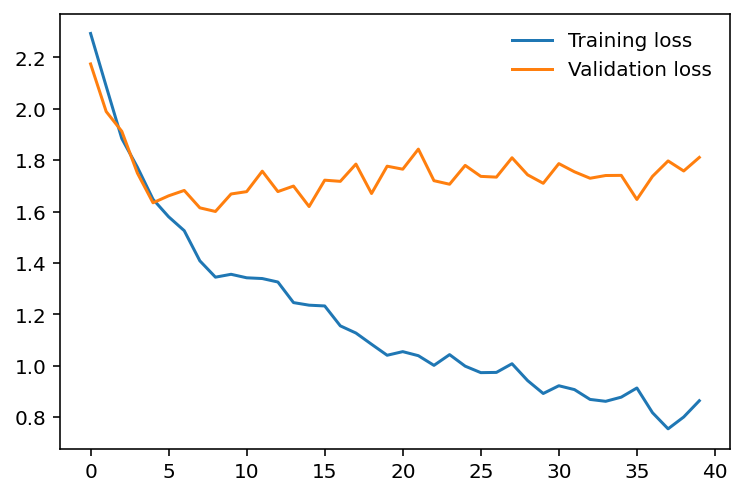

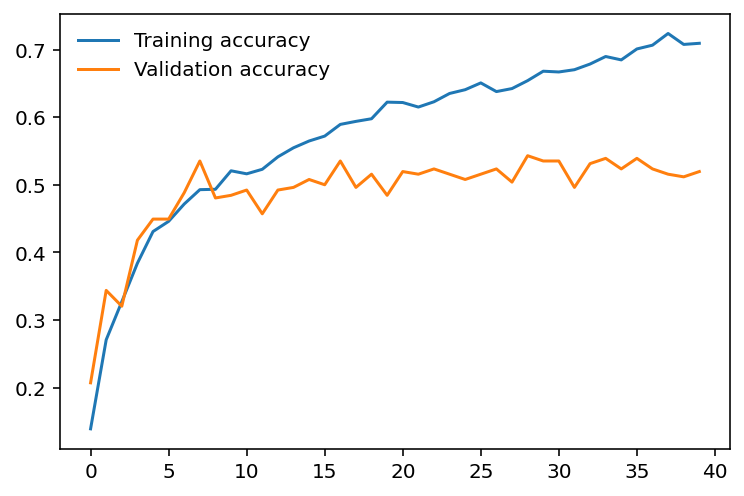

In [8]:
if mode == 'train':
    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'
    
    plt.plot(train_loss, label='Training loss')
    plt.plot(val_loss, label='Validation loss')
    plt.legend(frameon=False) 

    plt.figure() # 하나의 윈도우를 나타냄, 생략가능
    plt.plot(train_acc, label='Training accuracy')
    plt.plot(val_acc, label='Validation accuracy') 

    
    plt.legend(frameon=False) 